# Gerardo de Miguel González

**::GMG::** The aim of this notebook is to showcase the different approaches to feature selection using an advanced R framework like [caret](https://cran.r-project.org/web/packages/caret/)

# Caret Feature Selection Proof of Concept

## References

**::GMG::** I've followed these references:

  - [Machine Learning Process](https://machinelearningmastery.com/an-introduction-to-feature-selection/) An Introduction to Feature Selection. By Jason Brownlee on October 6, 2014.
  - [R Machine Learning](https://machinelearningmastery.com/feature-selection-with-the-caret-r-package/) Feature Selection with the Caret R Package. By Jason Brownlee on September 22, 2014
  - [Caret Package](http://topepo.github.io/caret/index.html) (See introductory [vignette](https://cran.r-project.org/web/packages/caret/vignettes/caret.html))

## Libraries

In [1]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [12]:
using('repr','mlbench', 'e1071', 'randomForest','caret', 'corrplot')

Loading required package: corrplot
corrplot 0.84 loaded


**::GMG::** First run caret installation

```R
Loading required package: mlbench
Loading required package: caTools
Loading required package: corrplot
corrplot 0.84 loaded
Loading required package: PRROC
Loading required package: caret
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘generics’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘recipes’
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2

    TRUE

```

**::GMG::** First run `e1071` wasn't installed

```R
Loading required package: e1071
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘e1071’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
Loading required package: e1071

    TRUE
```

In [37]:
#::GMG::Which libraries are there by default?
list.files(R.home('library'))

[1] "base"         "boot"         "class"        "cluster"      "codetools"   
 [6] "compiler"     "datasets"     "foreign"      "graphics"     "grDevices"   
[11] "grid"         "KernSmooth"   "lattice"      "MASS"         "Matrix"      
[16] "methods"      "mgcv"         "nlme"         "nnet"         "parallel"    
[21] "rpart"        "spatial"      "splines"      "stats"        "stats4"      
[26] "survival"     "tcltk"        "tools"        "translations" "utils"

In [38]:
#::GMG::more on listing loaded packages
# https://stat.ethz.ch/R-manual/R-patched/library/base/html/zpackages.html
# https://stackoverflow.com/questions/38481980/get-the-list-of-installed-packages-by-user-in-r
(.packages())

[1] "corrplot"     "caret"        "ggplot2"      "lattice"      "randomForest"
 [6] "e1071"        "mlbench"      "repr"         "stats"        "graphics"    
[11] "grDevices"    "utils"        "datasets"     "methods"      "base"

In [39]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] corrplot_0.84       caret_6.0-84        ggplot2_3.2.0      
[4] lattice_0.20-38     randomForest_4.6-14 e1071_1.7-2        
[7] mlbench_2.1-1       repr_1.0.1         

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.2         lubridate_1.7.4    class_7.3

## Dataset

In [3]:
#::GMG::With mlbench there's an aalternative to get the pima indians diabetes dataset
# https://cran.r-project.org/web/packages/mlbench/mlbench.pdf
data(PimaIndiansDiabetes2)

In [4]:
head(PimaIndiansDiabetes2)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,pos
1,85,66,29,NA,26.6,0.351,31,neg
8,183,64,NA,NA,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,NA,NA,25.6,0.201,30,neg


In [5]:
dim(PimaIndiansDiabetes2)

[1] 768   9

## Exploratory Data Analysis

### outliers

In [6]:
#::GMG::There are subtle differences between the kaggle and mlbench datasets
#       i.e. PimaIndiansDiabetes (say, v1) has the class as a factor (R compliant)
str(PimaIndiansDiabetes2)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 NA 70 96 ...
 $ triceps : num  35 29 NA 23 35 NA 32 NA 45 NA ...
 $ insulin : num  NA NA NA 94 168 NA 88 NA 543 NA ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 NA ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


**::GMG::** This dataset consists of 768 observations of 9 variables: 8 variables which will be used as model predictors (number of times pregnant, plasma glucose concentration, diastolic blood pressure (mm Hg), triceps skin fold thickness (in mm), 2-hr serum insulin measure, body mass index, a diabetes pedigree function, and age) and 1 outcome variable (whether or not the patient has diabetes). There are also **NA** missing values/outliers.

In [7]:
summary(PimaIndiansDiabetes2)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   : 44.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 64.00   1st Qu.:22.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :29.00  
 Mean   : 3.845   Mean   :121.7   Mean   : 72.41   Mean   :29.15  
 3rd Qu.: 6.000   3rd Qu.:141.0   3rd Qu.: 80.00   3rd Qu.:36.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
                  NA's   :5       NA's   :35       NA's   :227    
    insulin            mass          pedigree           age        diabetes 
 Min.   : 14.00   Min.   :18.20   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.: 76.25   1st Qu.:27.50   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median :125.00   Median :32.30   Median :0.3725   Median :29.00            
 Mean   :155.55   Mean   :32.46   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:190.00   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 M

In [8]:
#::GMG::Counting 'Outliers' a.k.a "physical impossibilities" (Zeros)
# https://stackoverflow.com/questions/22286957/count-the-number-of-non-zero-elements-of-each-column
#apply(X = PimaIndiansDiabetes[c("glucose", "pressure", "triceps", "insulin", "mass")], 
#      MARGIN = 2, 
#      FUN = function(c) sum(c == 0))
#::NOTE::I'm using the 2nd version of mlbench which has the zeros as NAs :)
print(sapply(PimaIndiansDiabetes2, function(x) sum(is.na(x))))

pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        5       35      227      374       11        0        0 
diabetes 
       0 


**::GMG::** Legacy code:

```R
#::GMG::What do I do with the outliers?
#       Glucose, Insulin, BloodPressure, SkinThickness, and BMI 
#       Options: remove, impute, leave them untouched (lto)
#       Chosen: remove (Glucose, BloodPressure, BMI) + lto (SkinThickness, Insulin)
# https://stackoverflow.com/questions/9977686/how-to-remove-rows-with-a-zero-value-in-r
#::NOTE::I cannot remove the outliers from SkinThickness and Insuline 
#        because they're a big slice of the dataset (!)
#row_sub <- apply(
#             X = PimaIndiansDiabetes[c("glucose", "pressure", "mass")], 
#             MARGIN = 1, 
#             FUN = function(row) all(row != 0)
#)
#
#::GMG::I remove some of the outliers
#pima_mod <- PimaIndiansDiabetes[row_sub,]
#
#::GMG::Remaining 'Outliers'
#apply(X = pima_mod[c("glucose", "pressure", "triceps", "insulin", "mass")], 
#      MARGIN = 2, 
#      FUN = function(c) sum(c == 0))

glucose
    0
pressure
    0
triceps
    192
insulin
    332
mass
    0
```


In [9]:
#::GMG::I reach a final decision here: emove NAs
#::NOTE::My goal here is feature selection showcase; of course, en tfm o real situation
#        I'll have to do imputation or selective removal
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/na.fail.html
# https://www.statmethods.net/input/missingdata.html
pima_clean <- stats::na.omit(PimaIndiansDiabetes2)

In [11]:
#::GMG::The somewhat cleaned dataset ...
str(pima_clean)

'data.frame':	392 obs. of  9 variables:
 $ pregnant: num  1 0 3 2 1 5 0 1 1 3 ...
 $ glucose : num  89 137 78 197 189 166 118 103 115 126 ...
 $ pressure: num  66 40 50 70 60 72 84 30 70 88 ...
 $ triceps : num  23 35 32 45 23 19 47 38 30 41 ...
 $ insulin : num  94 168 88 543 846 175 230 83 96 235 ...
 $ mass    : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ pedigree: num  0.167 2.288 0.248 0.158 0.398 ...
 $ age     : num  21 33 26 53 59 51 31 33 32 27 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 1 2 2 2 2 2 2 1 2 1 ...
 - attr(*, "na.action")= 'omit' Named int  1 2 3 6 8 10 11 12 13 16 ...
  ..- attr(*, "names")= chr  "1" "2" "3" "6" ...


### feature correlations

In [13]:
#::GMG::For Pima Indians Diabetes there are a bunch of features we can plot in a correlation graph with corrplot
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/cor.html
# https://www.statmethods.net/stats/correlations.html
#::NOTE::Se also https://www.statmethods.net/advgraphs/correlograms.html
M <- stats::cor(pima_clean[,!(colnames(pima_clean) == "diabetes")])

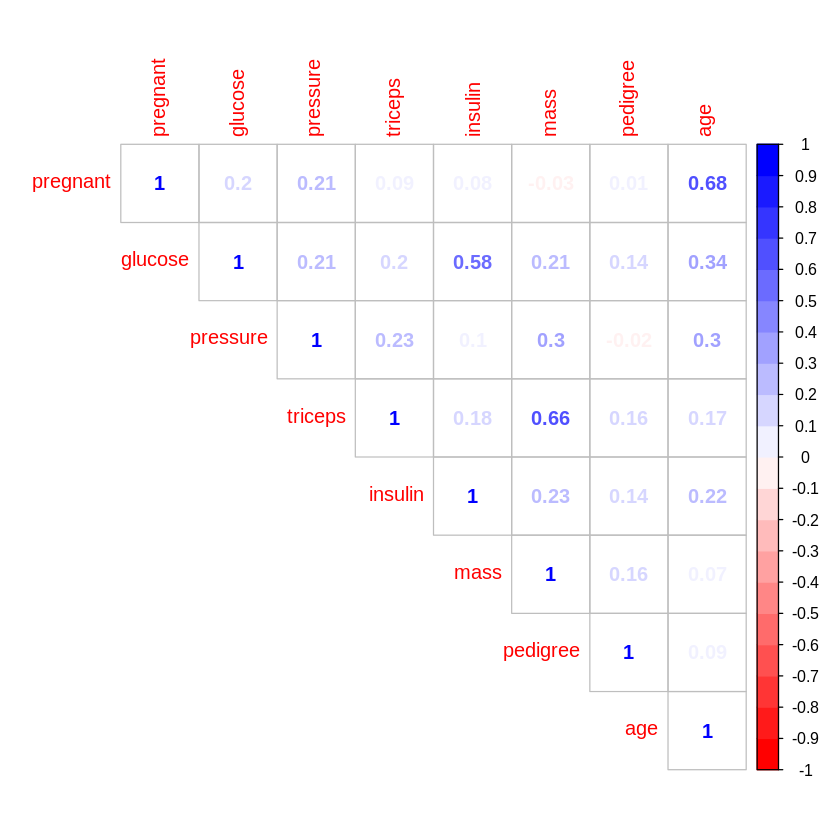

In [14]:
#::GMG::Plpot correlation plot
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
# https://www.rdocumentation.org/packages/grDevices/versions/3.6.1/topics/colorRamp
# https://www.rdocumentation.org/packages/corrplot/versions/0.84/topics/corrplot
col<- grDevices::colorRampPalette(c("red", "white", "blue"))(20)
corrplot::corrplot(M, method="number", type="upper", col = col)

In [15]:
#::GMG::Variables created so far :)
ls()

[1] "col"                  "M"                    "pima_clean"          
[4] "PimaIndiansDiabetes2" "using"

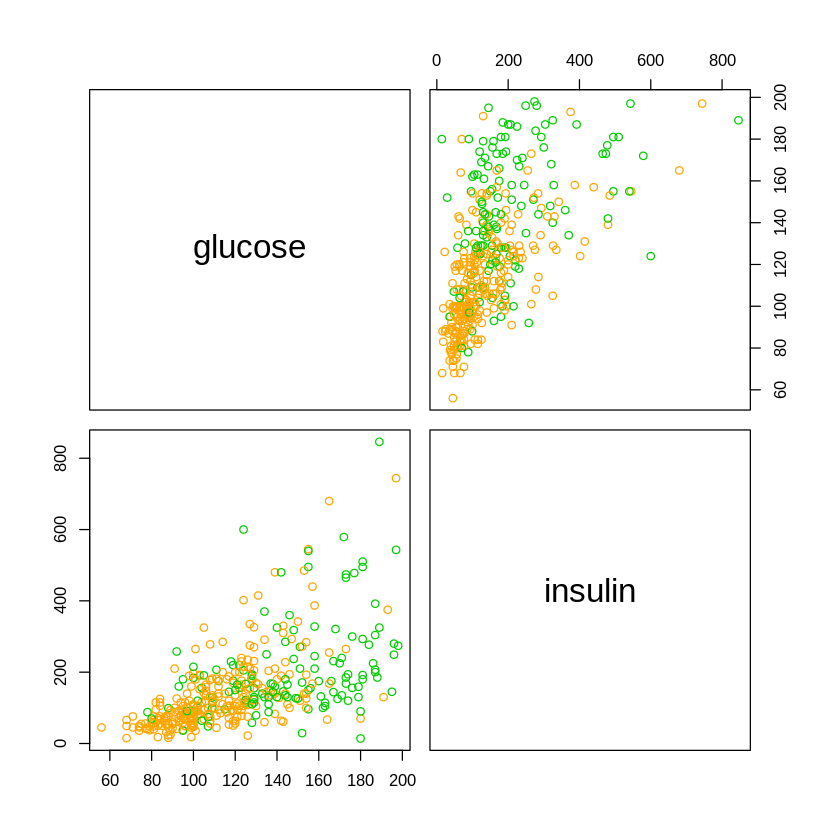

In [17]:
#::GMG::It's useful to look into pairs correlation taking into account the class variable
# https://www.rdocumentation.org/packages/graphics/versions/3.6.1/topics/pairs
graphics::pairs(glucose ~ insulin, 
                data = pima_clean, 
                col = c("orange", "green3")[unclass(pima_clean$diabetes)]
               )

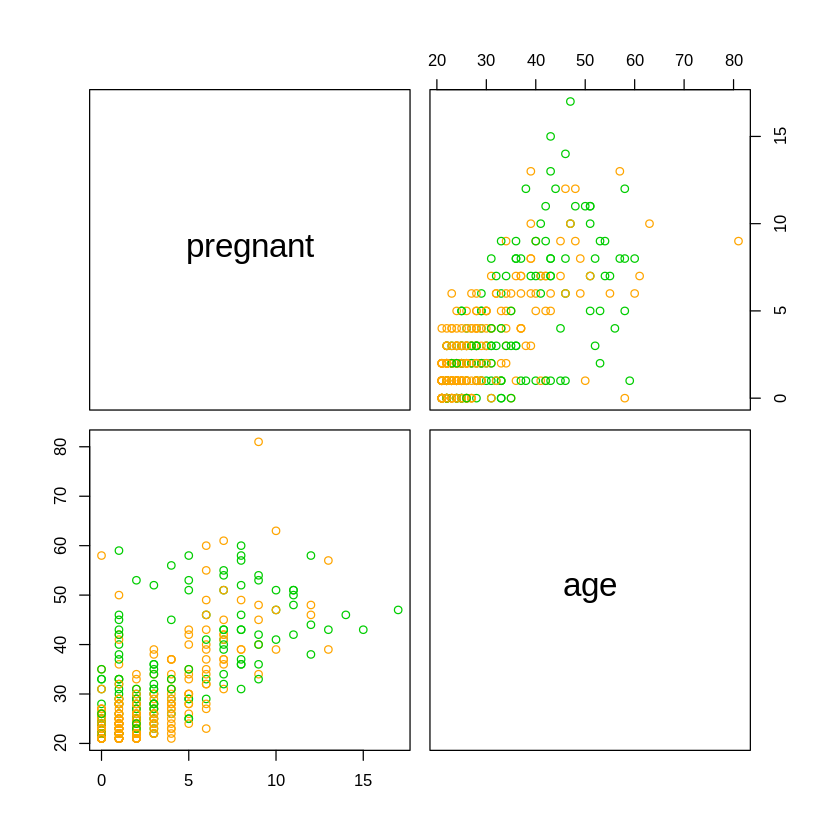

In [18]:
#::GMG::It's useful to look into pairs correlation taking into account the class variable
graphics::pairs(pregnant ~ age, 
                data = pima_clean, 
                col = c("orange", "green3")[unclass(pima_clean$diabetes)]
               )

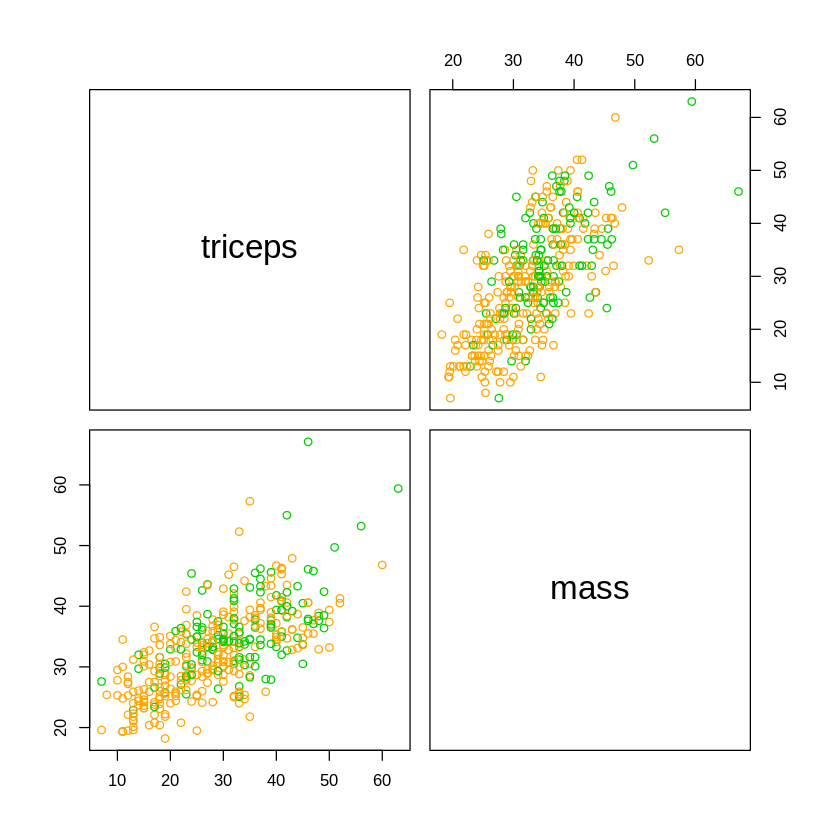

In [19]:
#::GMG::It's useful to look into pairs correlation taking into account the class variable
graphics::pairs(triceps ~ mass, 
                data = pima_clean, 
                col = c("orange", "green3")[unclass(pima_clean$diabetes)]
               )

### imbalance

In [20]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(pima_clean$diabetes)


neg pos 
262 130 

In [21]:
prop.table(table(pima_clean$diabetes))


      neg       pos 
0.6683673 0.3316327 

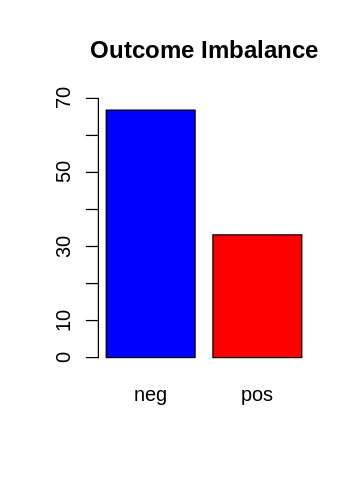

In [23]:
#::GMG::Plot the imbalance
# https://www.rdocumentation.org/packages/graphics/versions/3.6.1/topics/barplot
# https://www.statmethods.net/advgraphs/parameters.html
# http://www.programmingr.com/content/positioning-charts-fig-and-fin/
#par(pin = c(4,3))
options(repr.plot.width=3, repr.plot.height=4)
graphics::barplot(100*prop.table(table(pima_clean$diabetes)), 
        col = c('blue', 'red'),
        ylim = c(0,70),
        main = 'Outcome Imbalance')

## Filter: Correlation

### remove redundant features

In [25]:
#::GMG::I don't know why Jason set a seed when scouting for correlation/redudant features
set.seed(1)

In [26]:
#::GMG::calculate correlation matrix
# corelationMatrix <- cor(PimaIndiansDiabetes[,1:8])
#::NOTE::I've already done this with M (including class)
#::GMG::summarize the correlation matrix
#print(correlationMatrix)
print(M)

             pregnant   glucose   pressure   triceps    insulin        mass
pregnant  1.000000000 0.1982910  0.2133548 0.0932094 0.07898363 -0.02534728
glucose   0.198291043 1.0000000  0.2100266 0.1988558 0.58122301  0.20951592
pressure  0.213354775 0.2100266  1.0000000 0.2325712 0.09851150  0.30440337
triceps   0.093209397 0.1988558  0.2325712 1.0000000 0.18219906  0.66435487
insulin   0.078983625 0.5812230  0.0985115 0.1821991 1.00000000  0.22639652
mass     -0.025347276 0.2095159  0.3044034 0.6643549 0.22639652  1.00000000
pedigree  0.007562116 0.1401802 -0.0159711 0.1604985 0.13590578  0.15877104
age       0.679608470 0.3436415  0.3000389 0.1677611 0.21708199  0.06981380
             pedigree        age
pregnant  0.007562116 0.67960847
glucose   0.140180180 0.34364150
pressure -0.015971104 0.30003895
triceps   0.160498526 0.16776114
insulin   0.135905781 0.21708199
mass      0.158771043 0.06981380
pedigree  1.000000000 0.08502911
age       0.085029106 1.00000000


In [27]:
str(M)

 num [1:8, 1:8] 1 0.1983 0.2134 0.0932 0.079 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:8] "pregnant" "glucose" "pressure" "triceps" ...
  ..$ : chr [1:8] "pregnant" "glucose" "pressure" "triceps" ...


In [28]:
#::GMG::Working with named matrices
# https://monashbioinformaticsplatform.github.io/r-intro/matrices.html
M[,'pregnant']

pregnant      glucose     pressure      triceps      insulin         mass 
 1.000000000  0.198291043  0.213354775  0.093209397  0.078983625 -0.025347276 
    pedigree          age 
 0.007562116  0.679608470

In [29]:
str(M[,'pregnant'])

 Named num [1:8] 1 0.1983 0.2134 0.0932 0.079 ...
 - attr(*, "names")= chr [1:8] "pregnant" "glucose" "pressure" "triceps" ...


In [30]:
#::GMG::Subsetting with character array
print(M[row.names = c('glucose', 'pressure'), col.names = c('pedigree')])

   glucose   pressure 
 0.1401802 -0.0159711 


In [31]:
#::GMG::Subsetting
# http://adv-r.had.co.nz/Subsetting.html
M[1:8, 1:8]

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
pregnant,1.000000000,0.1982910,0.2133548,0.0932094,0.07898363,-0.02534728,0.007562116,0.67960847
glucose,0.198291043,1.0000000,0.2100266,0.1988558,0.58122301,0.20951592,0.140180180,0.34364150
pressure,0.213354775,0.2100266,1.0000000,0.2325712,0.09851150,0.30440337,-0.015971104,0.30003895
triceps,0.093209397,0.1988558,0.2325712,1.0000000,0.18219906,0.66435487,0.160498526,0.16776114
insulin,0.078983625,0.5812230,0.0985115,0.1821991,1.00000000,0.22639652,0.135905781,0.21708199
mass,-0.025347276,0.2095159,0.3044034,0.6643549,0.22639652,1.00000000,0.158771043,0.06981380
pedigree,0.007562116,0.1401802,-0.0159711,0.1604985,0.13590578,0.15877104,1.000000000,0.08502911
age,0.679608470,0.3436415,0.3000389,0.1677611,0.21708199,0.06981380,0.085029106,1.00000000


In [32]:
M[!(rownames(M) == "class"),!(colnames(M) == "class")]

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
pregnant,1.000000000,0.1982910,0.2133548,0.0932094,0.07898363,-0.02534728,0.007562116,0.67960847
glucose,0.198291043,1.0000000,0.2100266,0.1988558,0.58122301,0.20951592,0.140180180,0.34364150
pressure,0.213354775,0.2100266,1.0000000,0.2325712,0.09851150,0.30440337,-0.015971104,0.30003895
triceps,0.093209397,0.1988558,0.2325712,1.0000000,0.18219906,0.66435487,0.160498526,0.16776114
insulin,0.078983625,0.5812230,0.0985115,0.1821991,1.00000000,0.22639652,0.135905781,0.21708199
mass,-0.025347276,0.2095159,0.3044034,0.6643549,0.22639652,1.00000000,0.158771043,0.06981380
pedigree,0.007562116,0.1401802,-0.0159711,0.1604985,0.13590578,0.15877104,1.000000000,0.08502911
age,0.679608470,0.3436415,0.3000389,0.1677611,0.21708199,0.06981380,0.085029106,1.00000000


In [33]:
#::GMG::Conditional subsetting?
# https://www.r-bloggers.com/which-function-in-r/
which(M > 0.5 & M != 1, arr.ind = T, useNames = T)

,row,col
age,8,1
insulin,5,2
mass,6,4
glucose,2,5
triceps,4,6
pregnant,1,8


In [34]:
#::GMG::find attributes that are highly corrected (ideally >0.75)
#::NOTE::Do I need caret for this?
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/findCorrelation
# https://www.kaggle.com/questions-and-answers/42572
# https://rdrr.io/cran/caret/src/R/findCorrelation.R
#::NOTE::Here the description is relevant
#        The absolute values of pair-wise correlations are considered. If two variables have a high correlation, 
#        the function looks at the mean absolute correlation of each variable and removes the variable with the 
#        largest mean absolute correlation.
highlyCorrelated <- caret::findCorrelation(M, cutoff = 0.5, verbose = T, names = T)

Compare row 2  and column  5 with corr  0.581 
  Means:  0.269 vs 0.214 so flagging column 2 
Compare row 8  and column  1 with corr  0.68 
  Means:  0.253 vs 0.198 so flagging column 8 
Compare row 4  and column  6 with corr  0.664 
  Means:  0.267 vs 0.153 so flagging column 4 
All correlations <= 0.5 


In [35]:
#::GMG::print indexes of highly correlated attributes
#::NOTE::What indices?
print(highlyCorrelated)

[1] "glucose" "age"     "triceps"


**::QUESTION::** So ai guess `glucose`, `age` and `triceps` are candidates to elimination here. How do I show this removal to be useful? I mean, how do I show that after removing them there's some soft of improvement?

## Embedded: LVQ

### rank features by importance

**::GMG::** Here Jason uses [`lvq`](https://rdrr.io/cran/class/src/R/lvq.R) from package [`class`](https://cran.r-project.org/web/packages/class/index.html)([see documentation](https://cran.r-project.org/web/packages/class/class.pdf)) (which is loaded in the evironment by default) but using `caret` as a *framework* for setting the experiment: train, test and evaluation. This is a pattern I may replicate in my R code in TFM. I have two references of usage:

  - [datatechnotes](https://www.datatechnotes.com/2018/10/learning-vector-quantization.html) Classification with Learning Vector Quantization in R (2018)
  - [Medium](https://medium.com/@akshit.singh2504/using-learning-vector-quantization-for-classification-in-r-6be6588b471f) Using Learning Vector Quantization for Classification in R. By Akshit Singh (2019)

**::NOTE::** `lvq` is a *neural network model* so I guess it should be use when there are *a lot of features* or samples ... (**?**) and therefore I'm in doubt here because this dataset doesn't fit with the profile of an ideal candidate dataset (perhaps a GEO microarray gene expression dataset is better ...)

**::GMG::** Jason has also a reference about `lvq`:

  - [Understanding ML Algorithms](https://machinelearningmastery.com/learning-vector-quantization-for-machine-learning/) Learning Vector Quantization for Machine Learning. By Jason Brownlee on April 18, 2016

In [40]:
#::GMG::Now I'm using caret and I need to set the seed to make the experimet reproducble
set.seed(seed = 2)

In [41]:
#::GMG::prepare training scheme
#::NOTE::Best practice included, i.e using 3 repeated 10-fold CV
control <- caret::trainControl(method="repeatedcv", number=10, repeats=3)

In [43]:
#::GMG::train the model
#::NOTE::I use the original dataset, caret takes care of the train/test CV and whatnot
#        'lvq' is set by name but I guess lvq from CLASS it's used ... I'm in doubt at this point
#        scale pre-processing is flagged, which I know it's common in NN methods because is good for
#        backpropagation ... however, I don`t know if that is the case here.
#::ERROR::Error: package e1071 is required if not loaded :)
# https://cran.r-project.org/web/packages/e1071/e1071.pdf
#::NOTE::I don't think this library is needed here but caret need it in general. However I don't know
#        why it wasn't loaded along with caret!
model <- caret::train(diabetes~., 
               data = pima_clean, 
               method = "lvq", 
               preProcess = "scale", 
               trControl = control)

In [44]:
#::GMG::estimate variable importance
#::NOTE::There's a lot of to learned here
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/varImp
# https://topepo.github.io/caret/variable-importance.html
# https://stackoverflow.com/questions/37888619/difference-between-varimp-caret-and-importance-randomforest-for-random-fores
# https://stats.stackexchange.com/questions/113618/caret-package-in-r-get-top-variable-of-importance
importance <- caret::varImp(model, scale=FALSE)

In [45]:
str(importance)

List of 3
 $ importance:'data.frame':	8 obs. of  2 variables:
  ..$ neg: num [1:8] 0.621 0.806 0.621 0.659 0.73 ...
  ..$ pos: num [1:8] 0.621 0.806 0.621 0.659 0.73 ...
 $ model     : chr "ROC curve"
 $ calledFrom: chr "varImp"
 - attr(*, "class")= chr "varImp.train"


In [46]:
class(importance)

[1] "varImp.train"

In [47]:
#::GMG::I can print importanca
print(importance)

ROC curve variable importance

         Importance
glucose      0.8058
age          0.7432
insulin      0.7299
mass         0.6638
triceps      0.6594
pedigree     0.6215
pregnant     0.6214
pressure     0.6213


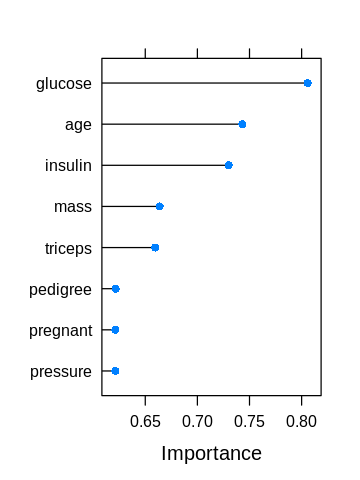

In [48]:
#::GMG:: And plot importance
plot(importance)

## Wrapper: RFE

In [49]:
ls()

[1] "col"                  "control"              "highlyCorrelated"    
[4] "importance"           "M"                    "model"               
[7] "pima_clean"           "PimaIndiansDiabetes2" "using"

In [50]:
#::GMG::define the control using a random forest selection function
#::NOTE::Then again caret takes care of split 10-fold CV
# https://topepo.github.io/caret/recursive-feature-elimination.html
#::NOTE::Shouldn`t I split train/test to validate at the end?
control_rfe <- caret::rfeControl(
    functions = rfFuncs, 
    method = "cv", 
    number = 10)

In [51]:
#::GMG::run the RFE algorithm form caret
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/rfe
results <- caret::rfe(
    pima_clean[,1:8], 
    pima_clean[,9], 
    sizes = c(1:8), 
    rfeControl = control_rfe)

In [52]:
str(results)

List of 17
 $ pred        : NULL
 $ variables   :'data.frame':	360 obs. of  6 variables:
  ..$ neg      : num [1:360] 26.42 12.51 10.89 6.16 5.49 ...
  ..$ pos      : num [1:360] 26.42 12.51 10.89 6.16 5.49 ...
  ..$ Overall  : num [1:360] 26.42 12.51 10.89 6.16 5.49 ...
  ..$ var      : chr [1:360] "glucose" "age" "insulin" "mass" ...
  ..$ Variables: int [1:360] 8 8 8 8 8 8 8 8 7 7 ...
  ..$ Resample : chr [1:360] "Fold01" "Fold01" "Fold01" "Fold01" ...
 $ results     :'data.frame':	8 obs. of  5 variables:
  ..$ Variables : int [1:8] 1 2 3 4 5 6 7 8
  ..$ Accuracy  : num [1:8] 0.724 0.778 0.783 0.791 0.778 ...
  ..$ Kappa     : num [1:8] 0.373 0.477 0.491 0.522 0.486 ...
  ..$ AccuracySD: num [1:8] 0.0711 0.0623 0.071 0.0434 0.0515 ...
  ..$ KappaSD   : num [1:8] 0.151 0.178 0.182 0.117 0.137 ...
 $ bestSubset  : int 4
 $ fit         :List of 18
  ..$ call           : language randomForest(x = x, y = y, importance = TRUE)
  ..$ type           : chr "classification"
  ..$ predicted   

In [53]:
class(results)

[1] "rfe"

In [54]:
#::GMG::summarize the results
#::NOTE::I can choose the metrics in rfe(), see doc
# https://topepo.github.io/caret/recursive-feature-elimination.html
print(results)


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.7245 0.3733    0.07105 0.15127         
         2   0.7780 0.4774    0.06230 0.17816         
         3   0.7830 0.4909    0.07104 0.18224         
         4   0.7908 0.5217    0.04335 0.11657        *
         5   0.7780 0.4862    0.05151 0.13657         
         6   0.7756 0.4755    0.03726 0.09712         
         7   0.7629 0.4472    0.04032 0.10562         
         8   0.7629 0.4440    0.05691 0.15471         

The top 4 variables (out of 4):
   glucose, age, insulin, mass



In [55]:
#::GMG::list the chosen features
#::NOTE::Note that in summary says that 
#        The top 5 variables (out of 8):
#        glucose, mass, age, pregnant, pedigree
predictors(results)

[1] "glucose" "age"     "insulin" "mass"

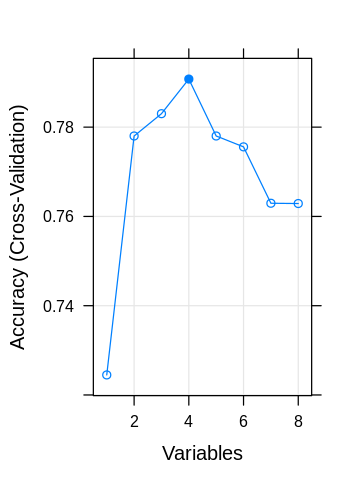

In [56]:
#::GMG::plot the results
plot(results, type=c("g", "o"))

**::GMG::** I think I should have a test set to validate the feature selection out of sample.